# LlamaIndex RAG Workflows using Gemini and Firestore

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/orchestration/llamaindex_workflows.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Forchestration%2Fllamaindex_workflows.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/orchestration/llamaindex_workflows.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/orchestration/llamaindex_workflows.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
| Author(s) | [Noa Ben-Efraim](https://github.com/noabenefraim) |

## Overview
LlamaIndex workflows are a powerful way to orchestrate complex LLM (large language model) applications. They provide an event-driven framework for building AI systems that go beyond simple question-answering.   

Think of a workflow as a series of steps, where each step performs a specific action. These actions can be anything from querying an LLM, to retrieving data from a vector database, to interacting with external APIs. The workflow manages the flow of data between these steps, making it easy to build sophisticated AI applications.   

Here's a breakdown of the key concepts:

+ Events: These trigger actions within the workflow. For example, a user's query can be an initial event that kicks off the workflow.   
+ Steps: These are individual functions decorated with @step that process events and potentially emit new events. Steps are the building blocks of your workflow.   
+ Event-driven: This means that the workflow reacts to events as they happen, making it flexible and dynamic.

This notebook perform a complex Retrieval Augmented Generation (RAG) workflow using Gemini models as well as Google Firestore databases. There are two branches for this workflow:

_Branch 1_
+ Start Event triggered by providing a data directory to the workflow
+ Ingest data using the LlamaIndex SimpleDirectoryReader
+ Load data in the Firestore Database

_Branch 2_
+ Start Event triggered by providing a query to the workflow
+ The QueryMultiStep Event that breaks down a complex query into sequential sub-questions using Gemini. Then proceeds to answer the sub-questions.
+ The sub-questions results are passed to the RerankEvent where given the initial user query, Gemini reranks the returned answers to the sub-questions.
+ The reranked chunks are passed to the CreateCitationEvents where citations are added to the sub-questions used to generate the answer.
+ An answer is synthesized for the original query and returned to the user.

References:
+ https://docs.llamaindex.ai/en/stable/examples/workflow/rag/
+ https://docs.llamaindex.ai/en/stable/examples/workflow/multi_step_query_engine/
+ https://docs.llamaindex.ai/en/stable/examples/workflow/citation_query_engine/

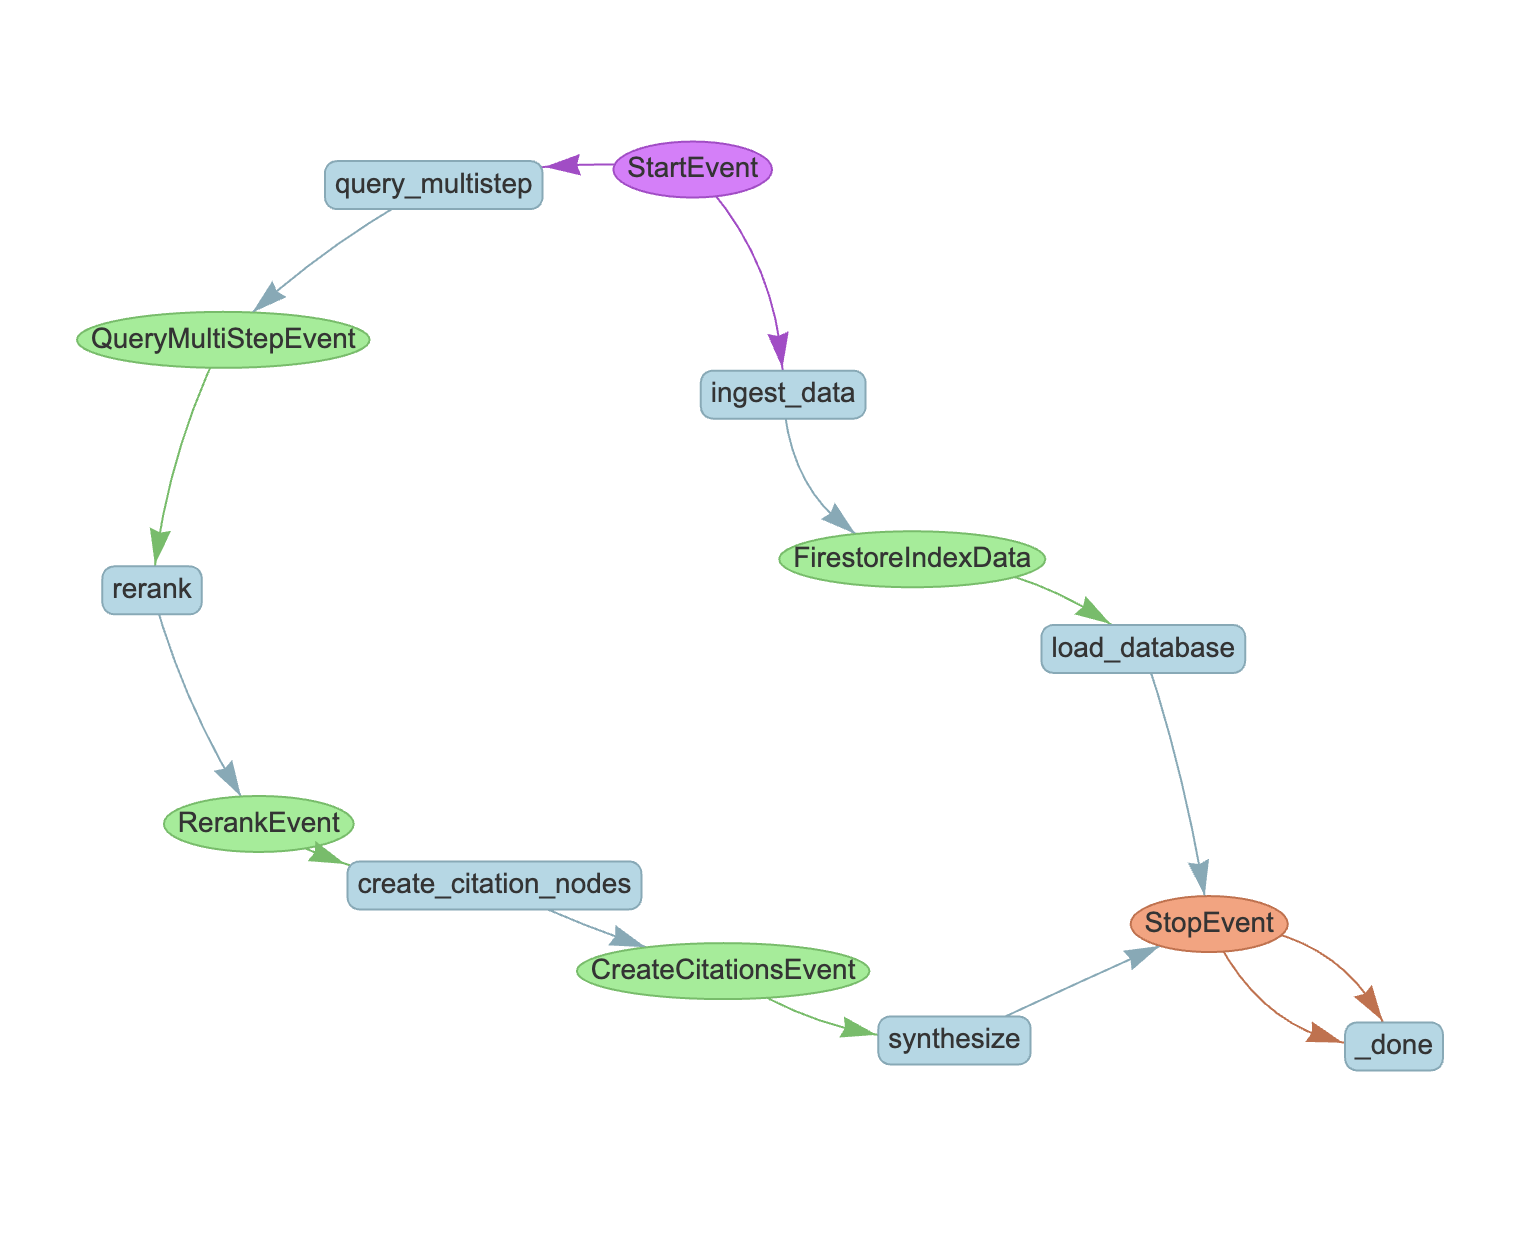

In [1]:
from IPython.display import Image

Image(
    filename="/home/noabe/generative-ai/gemini/orchestration/RAGWorkflow.png",
    width=500,
    height=500,
)

## Get started

### Install required packages


In [ ]:
%pip install llama-index=="0.11.8" \
    llama-index-embeddings-vertex=="0.2.0" \
    llama-index-utils-workflow=="0.2.1" \
    llama-index-llms-vertex=="0.3.4" \
    llama-index-storage-docstore-firestore=="0.2.0"

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK
This notebook requires the following resources:
+ initialized Google Cloud project
+ Vertex AI API enabled
+ existing VPC/Subnet
+ existing Firestore database

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

To get started using Firestore Database, refer to the following [documentation](https://cloud.google.com/firestore/docs/manage-databases).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).


In [1]:
# Use the environment variable if the user doesn't provide Project ID.
import os

import vertexai

PROJECT_ID = "[your-project-id]"  # @param {type:"string", isTemplate: true}
if PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")
FIRESTORE_DATABASE_ID = "[your-firestore-database-id]"

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Workflow

### Import libraries

In [1]:
from typing import Any, cast

from IPython.display import Markdown, display
from llama_index.core import (
    Settings,
    SimpleDirectoryReader,
    StorageContext,
    VectorStoreIndex,
)
from llama_index.core.indices.query.query_transform.base import (
    StepDecomposeQueryTransform,
)
from llama_index.core.llms import LLM
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.postprocessor.llm_rerank import LLMRerank
from llama_index.core.prompts import PromptTemplate
from llama_index.core.response_synthesizers import (
    ResponseMode,
    get_response_synthesizer,
)
from llama_index.core.schema import MetadataMode, NodeWithScore, QueryBundle, TextNode
from llama_index.core.workflow import (
    Context,
    Event,
    StartEvent,
    StopEvent,
    Workflow,
    step,
)
from llama_index.embeddings.vertex import VertexTextEmbedding
from llama_index.llms.vertex import Vertex
from llama_index.storage.docstore.firestore import FirestoreDocumentStore
from llama_index.utils.workflow import draw_all_possible_flows
from vertexai.generative_models import HarmBlockThreshold, HarmCategory, SafetySetting

### Get data

In [ ]:
!mkdir -p './data'
!wget 'https://www.gutenberg.org/cache/epub/64317/pg64317.txt' -O 'data/gatsby.txt'

### Set credentials

In [4]:
import google.auth
import google.auth.transport.requests

# credentials will now have an api token
credentials = google.auth.default(quota_project_id=PROJECT_ID)[0]
request = google.auth.transport.requests.Request()
credentials.refresh(request)

## Workflow

### Set up the LLM

In [ ]:
safety_config = [
    SafetySetting(
        category=HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold=HarmBlockThreshold.BLOCK_ONLY_HIGH,
    ),
    SafetySetting(
        category=HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold=HarmBlockThreshold.BLOCK_ONLY_HIGH,
    ),
    SafetySetting(
        category=HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold=HarmBlockThreshold.BLOCK_ONLY_HIGH,
    ),
]
embedding_model = VertexTextEmbedding(
    model_name="text-embedding-004", credentials=credentials
)
llm = Vertex(
    model="gemini-pro",
    temperature=0.2,
    max_tokens=3000,
    safety_settings=safety_config,
    credentials=credentials,
)

Settings.embed_model = embedding_model
Settings.llm = llm

### Define Event classes

Here we will create custom events that can be emitted by steps and trigger other steps. 


In [9]:
class RetrieverEvent(Event):
    """Result of running retrieval"""

    nodes: list[NodeWithScore]


class RerankEvent(Event):
    """Result of running reranking on retrieved nodes"""

    nodes: list[NodeWithScore]
    source_nodes: list[NodeWithScore]
    final_response_metadata: dict[str, Any]


class FirestoreIndexData(Event):
    """Result of indexing documents in Firestore"""

    status: str


class QueryMultiStepEvent(Event):
    """
    Event containing results of a multi-step query process.

    Attributes:
        nodes (List[NodeWithScore]): List of nodes with their associated scores.
        source_nodes (List[NodeWithScore]): List of source nodes with their scores.
        final_response_metadata (Dict[str, Any]): Metadata associated with the final response.
    """

    nodes: list[NodeWithScore]
    source_nodes: list[NodeWithScore]
    final_response_metadata: dict[str, Any]


class CreateCitationsEvent(Event):
    """Add citations to the nodes."""

    nodes: list[NodeWithScore]
    source_nodes: list[NodeWithScore]
    final_response_metadata: dict[str, Any]

### Update Prompt Templates

Defining custom prompts used for the citation portion of the workflow.

In [10]:
CITATION_QA_TEMPLATE = PromptTemplate(
    "Your task is to answer the question based on the information given in the sources listed below."
    "Use only the provided sources to answer."
    "Cite the source number(s) for any information you use in your answer (e.g., [1])."
    "Always include at least one source citation in your answer."
    "Only cite a source if you directly use information from it."
    "If the sources don't contain the information needed to answer the question, state that."
    "For example:"
    "Source 1: Apples are red, green, or yellow."
    "Source 2:  Bananas are yellow when ripe."
    "Source 3: Strawberries are red when ripe."
    "Query: Which fruits are red when ripe?"
    "Answer: Apples [1] and strawberries [3] can be red when ripe."
    "------"
    "Below are several numbered sources of information:"
    "------"
    "{context_str}"
    "------"
    "Query: {query_str}"
    "Answer: "
)

CITATION_REFINE_TEMPLATE = PromptTemplate(
    "You have an initial answer to a query."
    "Your job is to improve this answer using the information provided in the numbered sources below. Here's how:"
    " - Read the existing answer and the sources carefully."
    " - Identify any information in the sources that can improve the answer by adding details, making it more accurate, or providing better support."
    " - If the sources provide new information, incorporate it into the answer."
    " - If the sources contradict the existing answer, correct the answer."
    " - If the sources aren't helpful, keep the original answer."
    "Cite the source number(s) for any information you use in your answer (e.g., [1])."
    "We have provided an existing answer: {existing_answer}"
    "Below are several numbered sources of information. "
    "Use them to refine the existing answer. "
    "If the provided sources are not helpful, you will repeat the existing answer."
    "------"
    "{context_msg}"
    "------"
    "Query: {query_str}"
    "Answer: "
)

DEFAULT_CITATION_CHUNK_SIZE = 512
DEFAULT_CITATION_CHUNK_OVERLAP = 20

### Workflow Class

The RAGWorkflow() class contains all the steps of the workflow. We define the steps by decorating the method with @step.


In [11]:
class RAGWorkflow(Workflow):
    @step
    async def ingest_data(
        self, ctx: Context, ev: StartEvent
    ) -> FirestoreIndexData | None:
        """Entry point to ingest a document, triggered by a StartEvent with `dirname`."""
        dirname = ev.get("dirname")
        if not dirname:
            return None

        documents = SimpleDirectoryReader(dirname).load_data()
        await ctx.set("documents", documents)
        return FirestoreIndexData(
            status="First step complete. Data loaded into Documents."
        )

    @step
    async def load_database(self, ctx: Context, ev: FirestoreIndexData) -> StopEvent:
        print(ev.status)

        # create (or load) docstore and add nodes
        docstore = FirestoreDocumentStore.from_database(
            project=PROJECT_ID,
            database=FIRESTORE_DATABASE_ID,
        )

        docstore.add_documents(await ctx.get("documents"))

        # create storage context
        storage_context = StorageContext.from_defaults(docstore=docstore)

        # setup index
        index = VectorStoreIndex.from_documents(
            documents=await ctx.get("documents"), storage_context=storage_context
        )

        print("Index created")
        return StopEvent(index)

    def combine_queries(
        self,
        query_bundle: QueryBundle,
        prev_reasoning: str,
        llm: LLM,
    ) -> QueryBundle:
        """Combine queries using StepDecomposeQueryTransform."""
        transform_metadata = {"prev_reasoning": prev_reasoning}
        return StepDecomposeQueryTransform(llm=llm)(
            query_bundle, metadata=transform_metadata
        )

    def default_stop_fn(self, stop_dict: dict) -> bool:
        """Stop function for multi-step query combiner."""
        query_bundle = cast(QueryBundle, stop_dict.get("query_bundle"))
        if query_bundle is None:
            raise ValueError("Response must be provided to stop function.")

        return "none" in query_bundle.query_str.lower()

    @step(pass_context=True)
    async def query_multistep(
        self, ctx: Context, ev: StartEvent
    ) -> QueryMultiStepEvent | None:
        """Entry point for RAG, triggered by a StartEvent with `query`. Execute multi-step query process."""

        query = ev.get("query")
        index = ev.get("index")

        prev_reasoning = ""
        cur_response = None
        should_stop = False
        cur_steps = 0

        # use response
        final_response_metadata: dict[str, Any] = {"sub_qa": []}

        text_chunks = []
        source_nodes = []

        stop_fn = self.default_stop_fn

        if not query:
            return None

        print(f"Query the database with: {query}")

        # store the query in the global context
        await ctx.set("query", query)

        # get the index from the global context
        if index is None:
            print("Index is empty, load some documents before querying!")
            return None

        num_steps = ev.get("num_steps")
        query_engine = index.as_query_engine()

        while not should_stop:
            if num_steps is not None and cur_steps >= num_steps:
                should_stop = True
                break
            elif should_stop:
                break

            updated_query_bundle = self.combine_queries(
                QueryBundle(query_str=query),
                prev_reasoning,
                llm=Settings.llm,
            )

            print(
                f"Created query for the step - {cur_steps} is: {updated_query_bundle}"
            )

            stop_dict = {"query_bundle": updated_query_bundle}
            if stop_fn(stop_dict):
                should_stop = True
                break

            cur_response = query_engine.query(updated_query_bundle)

            # append to response builder
            cur_qa_text = (
                f"\nQuestion: {updated_query_bundle.query_str}\n"
                f"Answer: {cur_response!s}"
            )
            text_chunks.append(cur_qa_text)
            print("Source nodes used:\n")
            for source_node in cur_response.source_nodes:
                print(source_node)
                source_nodes.append(source_node)

            # update metadata
            final_response_metadata["sub_qa"].append(
                (updated_query_bundle.query_str, cur_response)
            )

            prev_reasoning += (
                f"- {updated_query_bundle.query_str}\n" f"- {cur_response!s}\n"
            )
            cur_steps += 1

        nodes = [
            NodeWithScore(node=TextNode(text=text_chunk)) for text_chunk in text_chunks
        ]
        return QueryMultiStepEvent(
            nodes=nodes,
            source_nodes=source_nodes,
            final_response_metadata=final_response_metadata,
        )

    @step
    async def rerank(self, ctx: Context, ev: QueryMultiStepEvent) -> RerankEvent:
        # Rerank the nodes
        ranker = LLMRerank(choice_batch_size=5, top_n=10, llm=Settings.llm)
        print("Entering reranking of nodes:\n")
        print("Original query: ", await ctx.get("query", default=None), flush=True)
        # print(await ctx.get("query", default=None), flush=True)
        try:
            new_nodes = ranker.postprocess_nodes(
                ev.nodes, query_str=await ctx.get("query", default=None)
            )
        except:
            # re ranker is not guaranteed to create parsable output
            new_nodes = ev.nodes

        print(f"Reranked nodes to {len(new_nodes)}")
        return RerankEvent(
            nodes=new_nodes,
            source_nodes=ev.source_nodes,
            final_response_metadata=ev.final_response_metadata,
        )

    @step
    async def create_citation_nodes(self, ev: RerankEvent) -> CreateCitationsEvent:
        """
        Modify retrieved nodes to create granular sources for citations.

        Takes a list of NodeWithScore objects and splits their content
        into smaller chunks, creating new NodeWithScore objects for each chunk.
        Each new node is labeled as a numbered source, allowing for more precise
        citation in query results.

        Args:
            nodes (List[NodeWithScore]): A list of NodeWithScore objects to be processed.

        Returns:
            List[NodeWithScore]: A new list of NodeWithScore objects, where each object
            represents a smaller chunk of the original nodes, labeled as a source.
        """
        nodes = ev.nodes

        new_nodes: list[NodeWithScore] = []

        text_splitter = SentenceSplitter(
            chunk_size=DEFAULT_CITATION_CHUNK_SIZE,
            chunk_overlap=DEFAULT_CITATION_CHUNK_OVERLAP,
        )

        for node in nodes:
            print(node)

            text_chunks = text_splitter.split_text(
                node.node.get_content(metadata_mode=MetadataMode.NONE)
            )

            for text_chunk in text_chunks:
                text = f"Source {len(new_nodes)+1}:\n{text_chunk}\n"

                new_node = NodeWithScore(
                    node=TextNode.model_validate(node.node), score=node.score
                )

                new_node.node.text = text
                new_nodes.append(new_node)
        return CreateCitationsEvent(
            nodes=new_nodes,
            source_nodes=ev.source_nodes,
            final_response_metadata=ev.final_response_metadata,
        )

    @step
    async def synthesize(self, ctx: Context, ev: CreateCitationsEvent) -> StopEvent:
        """Return a streaming response using reranked nodes."""

        print("Synthesizing final result...")

        response_synthesizer = get_response_synthesizer(
            llm=Vertex(model="gemini-pro", temperature=0.0, max_tokens=5000),
            text_qa_template=CITATION_QA_TEMPLATE,
            refine_template=CITATION_REFINE_TEMPLATE,
            response_mode=ResponseMode.COMPACT,
            use_async=True,
        )
        query = await ctx.get("query", default=None)
        response = await response_synthesizer.asynthesize(
            query, nodes=ev.nodes, additional_source_nodes=ev.source_nodes
        )
        return StopEvent(result=response)

In [ ]:
# optional - generate DAG for workflow created above
draw_all_possible_flows(workflow=RAGWorkflow, filename="multi_step_workflow.html")  # type: ignore

### Run the workflow

In [12]:
w = RAGWorkflow(timeout=200)

In [13]:
# Ingest the documents
index = await w.run(dirname="./data")

First step complete. Data loaded into Documents.
Index created


#### Example 1
Query: _"What is the significance of the green light?"_

In [20]:
# Run a query
NUM_STEPS = 2  # @param {type:"int"} represents how many sub-questions generated based on the query
result = await w.run(
    query="What is the significance of the green light?",
    index=index,
    num_steps=NUM_STEPS,
)

display(Markdown(f"{result}"))

Query the database with: What is the significance of the green light?
Created query for the step - 0 is: What is the significance of the green light?
Source nodes used:

Node ID: 5eb87b99-9b78-4b4b-b99d-6d8775c7c7d6
Text: Its vanished trees, the trees that had made way for Gatsby’s
house, had once pandered in whispers to the last and greatest of all
human dreams; for a transitory enchanted moment man must have held his
breath in the presence of this continent, compelled into an aesthetic
contemplation he neither understood nor desired, face to face for the
l...
Score:  0.540

Node ID: d39f1465-793e-409f-8677-80868d124fe9
Text: “I’ve got a man in England who buys me clothes. He sends over a
selection of things at the beginning of each season, spring and fall.”
He took out a pile of shirts and began throwing them, one by one,
before us, shirts of sheer linen and thick silk and fine flannel,
which lost their folds as they fell and covered the table in  many-
coloure...
Score:  0.525

Crea

## The Significance of the Green Light

The green light at the end of Daisy's dock holds immense symbolic weight in *The Great Gatsby*. It represents Gatsby's yearning for Daisy and the American Dream, both of which remain ultimately unattainable. 

**Hope and Dreams:**

* The green light embodies Gatsby's fervent hope for a future with Daisy. It symbolizes his desire to recapture the past and relive the passionate love they once shared (Source 1). 
* It also represents Gatsby's unwavering belief in the American Dream, the idea that anyone can achieve success and happiness through hard work and determination (Source 1). 

**Unattainable Desire:**

* Despite Gatsby's relentless pursuit, the green light remains just out of reach, symbolizing the impossibility of recapturing the past and the ultimate futility of his efforts (Source 2). 
* As Gatsby's obsession with the green light intensifies, it leads him down a path of self-destruction, highlighting the dangers of pursuing unattainable dreams (Source 2). 

**Disillusionment and Disappointment:**

* When Gatsby finally reunites with Daisy, he realizes that she is not the woman he once idealized. This realization shatters his dream and leaves him disillusioned and disappointed (Source 2). 
* The green light becomes a symbol of the harsh reality that Gatsby must confront, highlighting the fleeting nature of dreams and the potential for heartbreak when pursuing them (Source 2). 

**Symbol of Illusion:**

* The green light ultimately represents the illusory nature of Gatsby's dreams. It serves as a reminder that even the most fervent desires can be elusive and that the pursuit of unattainable goals can lead to disappointment and despair (Source 2). 

**Character Development:**

* The green light plays a crucial role in Gatsby's character development. It reveals his unwavering hope, relentless determination, and ultimately, his tragic downfall (Source 2). 

**Conclusion:**

The green light is a powerful symbol that encapsulates the themes of hope, unattainable dreams, disillusionment, and the American Dream in *The Great Gatsby*. It serves as a poignant reminder of the dangers of pursuing unrealistic goals and the importance of accepting the limitations of reality. 


Check the ranked LLM generated sub-question answers used:

In [21]:
for idx in range(0, NUM_STEPS):
    print(result.source_nodes[idx])

Node ID: e464e386-a68c-417a-9781-8617c7f714dc
Text: Source 1: Question: What is the significance of the green light?
Answer: The green light is a symbol of Gatsby's hope and dreams. It
represents his desire to be reunited with Daisy and to recapture the
past. The light is also a symbol of the American Dream, which Gatsby
believes he can achieve through hard work and determination. However,
the gr...
Score: None

Node ID: bfb7b492-db8e-4bc5-8c5e-1fafe38dc8df
Text: Source 2: Question: ## What is the significance of the green
light in the context of Gatsby's character development?   Answer: The
green light at the end of Daisy's dock is a significant symbol in the
novel, representing Gatsby's unattainable dream of love and happiness
with Daisy. It is a physical manifestation of his longing and desire,
a beac...
Score: None



Check the citations from the original source used:

In [22]:
for idx in range(NUM_STEPS, len(result.source_nodes)):
    print(result.source_nodes[idx])

Node ID: 5eb87b99-9b78-4b4b-b99d-6d8775c7c7d6
Text: Its vanished trees, the trees that had made way for Gatsby’s
house, had once pandered in whispers to the last and greatest of all
human dreams; for a transitory enchanted moment man must have held his
breath in the presence of this continent, compelled into an aesthetic
contemplation he neither understood nor desired, face to face for the
l...
Score:  0.540

Node ID: d39f1465-793e-409f-8677-80868d124fe9
Text: “I’ve got a man in England who buys me clothes. He sends over a
selection of things at the beginning of each season, spring and fall.”
He took out a pile of shirts and began throwing them, one by one,
before us, shirts of sheer linen and thick silk and fine flannel,
which lost their folds as they fell and covered the table in  many-
coloure...
Score:  0.525

Node ID: 702255e1-6bb5-4b58-89b8-3a97dbc10eea
Text: “Old sport, the dance is unimportant.”    He wanted nothing less
of Daisy than that she should go to Tom and  say: “I neve

#### Example 2

Query: How are Gatsby and Nick character foils to each other?

In [12]:
# Run a query
NUM_STEPS = 2  # @param {type:"int"} represents how many sub-questions generated based on the query
result = await w.run(
    query="How are Gatsby and Nick character foils to each other?",
    index=index,
    num_steps=NUM_STEPS,
)

display(Markdown(f"{result}"))

Query the database with: How are Gatsby and Nick character foils to eachother?
Created query for the step - 0 is: What are the key characteristics of Gatsby and Nick? 

Source nodes used:

Node ID: a340be5b-facc-46e6-bc72-f51599b225eb
Text: ﻿The Project Gutenberg eBook of The Great Gatsby        This
ebook is for the use of anyone anywhere in the United States and  most
other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at ww...
Score:  0.606

Node ID: 16c7dd04-e26b-4dd6-ad65-a86e2bcc5350
Text: “You ought to go away,” I said. “It’s pretty certain they’ll
trace  your car.”    “Go away now, old sport?”    “Go to Atlantic City
for a week, or up to Montreal.”    He wouldn’t consider it. He
couldn’t possibly leave Daisy until he  knew what she was going to do.
He was clutching at some last hope and  I couldn’t bear to shake him
free.    

## Gatsby and Nick as Character Foils

Gatsby and Nick serve as character foils in "The Great Gatsby," highlighting contrasting personalities, values, and approaches to life. Their differences illuminate the novel's central themes of wealth, love, and the American Dream.

**Personality:**

* **Gatsby:** Extroverted, mysterious, driven, romantic, idealistic, tragic.
* **Nick:** Introverted, observant, moral, reserved, compassionate, detached.

**Values:**

* **Gatsby:** Materialistic, focused on wealth and status, believes money can buy happiness.
* **Nick:** More complex, attracted to wealth but aware of its emptiness, seeks meaning beyond material possessions.

**Approach to Life:**

* **Gatsby:** Obsessed with the past, seeks to recapture lost love, throws lavish parties to impress.
* **Nick:** Focused on the present, observes and reflects, seeks genuine connection and understanding.

**Foil Relationship:**

* Gatsby's extravagance and materialism contrast with Nick's moral reservations and introspective nature.
* Gatsby's relentless pursuit of an impossible dream highlights Nick's search for meaning and authenticity.
* Gatsby's tragic downfall underscores the dangers of materialism and the illusion of the American Dream, while Nick's journey suggests the possibility of finding fulfillment through self-discovery and genuine connection.

**Sources:**

* **Source 1:** Provides a detailed analysis of Gatsby and Nick's key characteristics, highlighting their contrasting personalities, values, and motivations.
* **Source 2:** Further emphasizes the differences between Gatsby and Nick, focusing on their contrasting values and approaches to life.

**Conclusion:**

Gatsby and Nick's contrasting personalities and values make them effective character foils, illuminating the novel's central themes and providing a nuanced exploration of the human condition. Their relationship highlights the dangers of materialism, the allure of the American Dream, and the importance of finding meaning and authenticity in life. 


Check the ranked LLM generated sub-question answers used:

In [13]:
for idx in range(0, NUM_STEPS):
    print(result.source_nodes[idx])

Node ID: 6d7b2be2-fee0-47d6-b8d9-df11edf63591
Text: Source 1: Question: What are the key characteristics of Gatsby
and Nick?   Answer: ## Key Characteristics of Gatsby and Nick  Based
on the provided excerpt from "The Great Gatsby":  **Gatsby:**  *
**Romantic and idealistic:** He has an "extraordinary gift for hope"
and is "related to one of those intricate machines that register
earthquakes ten ...
Score: None

Node ID: 8386b630-226d-49d9-9a4c-c8ab8ed35d4e
Text: Source 2: Question: How do Gatsby's and Nick's personalities and
values differ?   Answer: Gatsby is a mysterious and enigmatic figure
who is shrouded in secrecy. He is known for his lavish parties and his
extravagant lifestyle, but his true identity and past are unknown.
Nick, on the other hand, is a more reserved and introspective
character who...
Score: None



Check the citations from the original source used:

In [14]:
for idx in range(NUM_STEPS, len(result.source_nodes)):
    print(result.source_nodes[idx])

Node ID: a340be5b-facc-46e6-bc72-f51599b225eb
Text: ﻿The Project Gutenberg eBook of The Great Gatsby        This
ebook is for the use of anyone anywhere in the United States and  most
other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at ww...
Score:  0.606

Node ID: 16c7dd04-e26b-4dd6-ad65-a86e2bcc5350
Text: “You ought to go away,” I said. “It’s pretty certain they’ll
trace  your car.”    “Go away now, old sport?”    “Go to Atlantic City
for a week, or up to Montreal.”    He wouldn’t consider it. He
couldn’t possibly leave Daisy until he  knew what she was going to do.
He was clutching at some last hope and  I couldn’t bear to shake him
free.    It ...
Score:  0.601

Node ID: a340be5b-facc-46e6-bc72-f51599b225eb
Text: ﻿The Project Gutenberg eBook of The Great Gatsby        This
ebook is for the use of anyone anywhere in the United 

## Cleaning up

To clean up all Google Cloud resources used in this project, you can delete the Google Cloud project you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.